# Data Science Bowl 2017

The yearly tradition continues! - this time with another computer vision problem. we have to classify whether someone will be diagnosed with **lung cancer** at some point during the next year. We are given DICOM files, which is a format that is often used for medical scans. Using CT scans from 1400 patients in the training set, we have to build a model which can predict on the patients in the test set.

**Shameless plug:** If you have any questions or want to discuss competitions/hardware/games/anything with other Kagglers, then join the [KaggleNoobs Slack channel](https://goo.gl/gGWFXe)! I feel like it could use a lot more users :)

**And as always, if this helped you, some upvotes would be very much appreciated! :D**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
%matplotlib inline
p = sns.color_palette()

os.listdir('../input')

['sample_images', 'stage1_sample_submission.csv', 'stage1_labels.csv']

It looks like this time, we have been given the sample submission, the labels for the training set, and a sample submission for a test set.

# The image data

First, let's look at the sample images!

In [2]:
for d in os.listdir('../input/sample_images'):
    print("Patient '{}' has {} scans".format(d, len(os.listdir('../input/sample_images/' + d))))
print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir('../input/sample_images')), 
                                                      len(glob.glob('../input/sample_images/*/*.dcm'))))

Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0d06d764d3c07572074d468b4cff954f' has 435 scans
Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0a099f2549429d29b32f349e95fb2244' has 128 scans
Patient '0c0de3749d4fe175b7a509

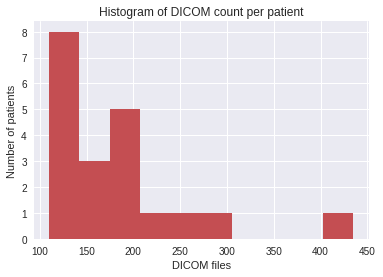

In [3]:
patient_sizes = [len(os.listdir('../input/sample_images/' + d)) for d in os.listdir('../input/sample_images')]
plt.hist(patient_sizes, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')

We can see that the sample_images directory is made up of a bunch of subdirectories, each representing a single patient ID and containing about 100-300 DICOM files inside (except one with over 400).

What about file size?

In [4]:
sizes = [os.path.getsize(dcm)/1000000 for dcm in glob.glob('../input/sample_images/*/*.dcm')]
print('DCM file sizes: min {:.3}MB max {:.3}MB avg {:.3}MB std {:.3}MB'.format(np.min(sizes), 
                                                       np.max(sizes), np.mean(sizes), np.std(sizes)))

DCM file sizes: min 0.525MB max 0.526MB avg 0.525MB std 3.74e-05MB


We can see here that basically all the DICOM files are the same 0.525MB size - which makes it seem like they are uncompressed files with the same amount of information.

We'll come back to images to load them in a second, but first let's look at the other two files.

# Training set

In [5]:
df_train = pd.read_csv('../input/stage1_labels.csv')
df_train.head()

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


Simple enough. Let's look at the data stats:

In [6]:
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))

Number of training patients: 1397
Cancer rate: 25.91%


Here we can see that in the training set we have a total of just under 1400 patients, of which just over a quarter have had lung cancer diagnosed in the year after these scans were taken.

Let's see if we can exploit this information to beat the benchmark on the leaderboard!

### Naive Submission

Since the evaluation metric used in this competition is [LogLoss](https://www.kaggle.com/wiki/LogarithmicLoss) and not something like [AUC](https://www.kaggle.com/wiki/AreaUnderCurve), this means that we can often gain an improvement just by aligning the probabilities of our sample submission to that of the training set.

Before I try making a naive submission, I will calculate what the score of this submission would be on the training set to get a comparison.

In [7]:
from sklearn.metrics import log_loss
logloss = log_loss(df_train.cancer, np.zeros_like(df_train.cancer) + df_train.cancer.mean())
print('Training logloss is {}'.format(logloss))

Training logloss is 0.5721414894789518


Wow, not bad. Let's turn it into a submission.

In [8]:
sample = pd.read_csv('../input/stage1_sample_submission.csv')
sample['cancer'] = df_train.cancer.mean()
sample.to_csv('naive_submission.csv', index=False)

This submission scores **0.60235** on the leaderboard - you can try it out for yourself by heading over to the **Output** tab at the top of the kernel.

The fact that the score is worse here shows us that we have [overfitted](https://xkcd.com/605/) to our training data. The mean of the test set is different than the mean of the training set, and while this may only be a small difference, it is the reason why the score is worse on the leaderboard. But we won't be winning any prizes for this submission anyway, so it's time to move on :)

### Leakbusters

Just as a quick sanity check, I'm going to check to see whether there's any observable relationship between Patient ID and whether they have cancer or not. Let's hope they used better random seeds than TalkingData #neverforget

Note that in the following graph, it is also in order of PatientID as the rows have been presorted.

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  app.launch_new_instance()


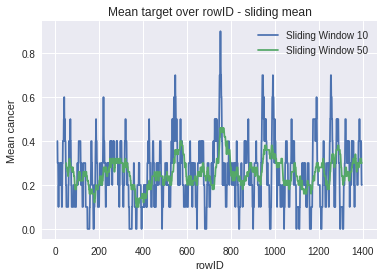

In [9]:
targets = df_train['cancer']
plt.plot(pd.rolling_mean(targets, window=10), label='Sliding Window 10')
plt.plot(pd.rolling_mean(targets, window=50), label='Sliding Window 50')
plt.xlabel('rowID')
plt.ylabel('Mean cancer')
plt.title('Mean target over rowID - sliding mean')
plt.legend()

In [10]:
print('Accuracy predicting no cancer: {}%'.format((df_train['cancer'] == 0).mean()))
print('Accuracy predicting with last value: {}%'.format((df_train['cancer'] == df_train['cancer'].shift()).mean()))

Accuracy predicting no cancer: 0.740873299928418%
Accuracy predicting with last value: 0.6148890479599141%


There no leak here which is immediately apparent to me - it looks well sorted. Feel free to disagree if you've noticed something!

# Test set (Stage 1)

After looking at the training file for a bit, let's take a brief look at the test set/sample submission.

In [11]:
sample = pd.read_csv('../input/stage1_sample_submission.csv')
sample.head()

,id,cancer
0,026470d51482c93efc18b9803159c960,0.5
1,031b7ec4fe96a3b035a8196264a8c8c3,0.5
2,03bd22ed5858039af223c04993e9eb22,0.5
3,06a90409e4fcea3e634748b967993531,0.5
4,07b1defcfae5873ee1f03c90255eb170,0.5


In [12]:
print('The test file has {} patients'.format(len(sample)))

The test file has 198 patients


Nothing out of the ordinary here, the submission file is arranged very similarly to the training csv, except that we submit a probability instead of a class predction. There are less than 200 samples, which means that we need to watch out for overfitting on the leaderboard.

It is actually possible to get a perfect score only through brute force in Stage 1 - as we have 200 samples and over 200 submissions to test on the LB. So expect lots of overfitting. [Trust no one, not even yourself.](http://i1.kym-cdn.com/entries/icons/original/000/017/046/BptVE1JIEAAA3dT.jpg)

# DICOMs

The dicom package was finally added! Here's some quick exploration of the files and what they contain.

First, I'll just load a random image from the lot.

In [13]:
import dicom

In [14]:
dcm = '../input/sample_images/0a38e7597ca26f9374f8ea2770ba870d/4ec5ef19b52ec06a819181e404d37038.dcm'
print('Filename: {}'.format(dcm))
dcm = dicom.read_file(dcm)

Filename: ../input/sample_images/0a38e7597ca26f9374f8ea2770ba870d/4ec5ef19b52ec06a819181e404d37038.dcm


Now I've read a random image, let's view the information inside.

In [15]:
dcm

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.160978843216949953815246551971491067836
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '0a38e7597ca26f9374f8ea2770ba870d'
(0010, 0020) Patient ID                          LO: '0a38e7597ca26f9374f8ea2770ba870d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.13148394979245937484165594540025668927189308811493143066650
(0020, 000e) Series Instance UID                 UI: 2.25.53298563728906335585833752405238884704498238267638676785109
(0020, 0011) Series Number                       IS: '2'
(0020, 0012) Acquisition Number            

It looks this data has been intentionally anonymised in order to keep this a computer vision problem. Notably, the birth date has been anonymised to January 1st, 1900. Age could otherwise be an important feature for predicting lung cancer.

There are two things here that I think are significant, slice location (this sounds like it could be the z-position of the scan?) and the 'Pixel Data'.

We can retrieve a image as a **numpy array** by calling `dcm.pixel_array`, and we can then replace the -2000s, which are essentially NAs, with 0s (thanks r4m0n).

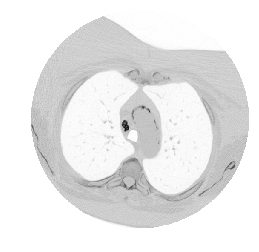

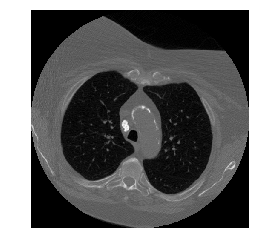

In [16]:
img = dcm.pixel_array
img[img == -2000] = 0

plt.axis('off')
plt.imshow(img)
plt.show()

plt.axis('off')
plt.imshow(-img) # Invert colors with -
plt.show()

Let's plot a few more images at random:

In [17]:
def dicom_to_image(filename):
    dcm = dicom.read_file(filename)
    img = dcm.pixel_array
    img[img == -2000] = 0
    return img

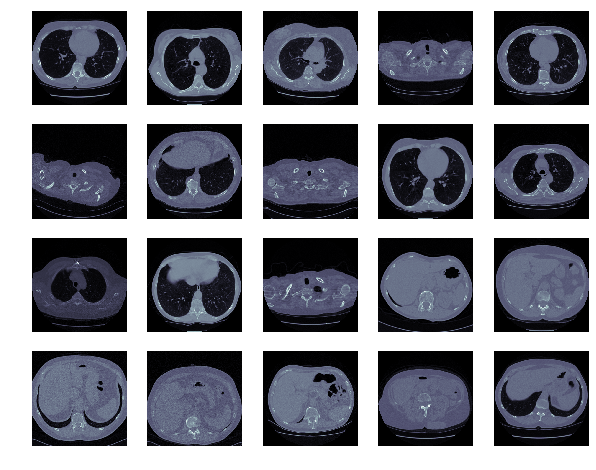

In [18]:
files = glob.glob('../input/sample_images/*/*.dcm')

f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image(np.random.choice(files)), cmap=plt.cm.bone)

This gives us some idea with the sort of images we're dealing with. Now, let's try to reconstruct the layers of the body from which the images were taken, by taking a single patient and sorting his scans by Slice Location.

In [19]:
def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

# Returns a list of images for that patient_id, in ascending order of Slice Location
def load_patient(patient_id):
    files = glob.glob('../input/sample_images/{}/*.dcm'.format(patient_id))
    imgs = {}
    for f in files:
        dcm = dicom.read_file(f)
        img = dcm.pixel_array
        img[img == -2000] = 0
        sl = get_slice_location(dcm)
        imgs[sl] = img
        
    # Not a very elegant way to do this
    sorted_imgs = [x[1] for x in sorted(imgs.items(), key=lambda x: x[0])]
    return sorted_imgs

In [20]:
pat = load_patient('0a38e7597ca26f9374f8ea2770ba870d')

Now that we have the images of a patient sorted by position in the body, we can plot them to see how this varies.

It's worth noting that this patient does **not** have cancer.

### Sorted Slices of Patient 0a38e7597ca26f9374f8ea2770ba870d - No cancer

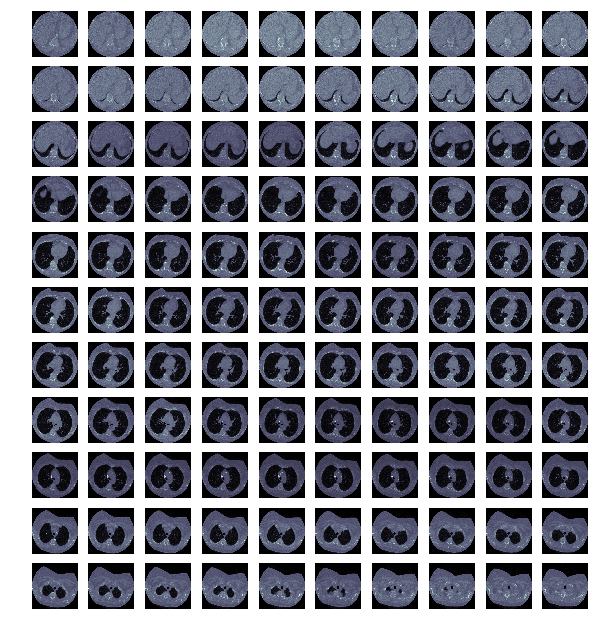

In [21]:
f, plots = plt.subplots(11, 10, sharex='all', sharey='all', figsize=(10, 11))
# matplotlib is drunk
#plt.title('Sorted Slices of Patient 0a38e7597ca26f9374f8ea2770ba870d - No cancer')
for i in range(110):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pat[i], cmap=plt.cm.bone)

### Sorted Slices of Patient 0acbebb8d463b4b9ca88cf38431aac69 - Cancer

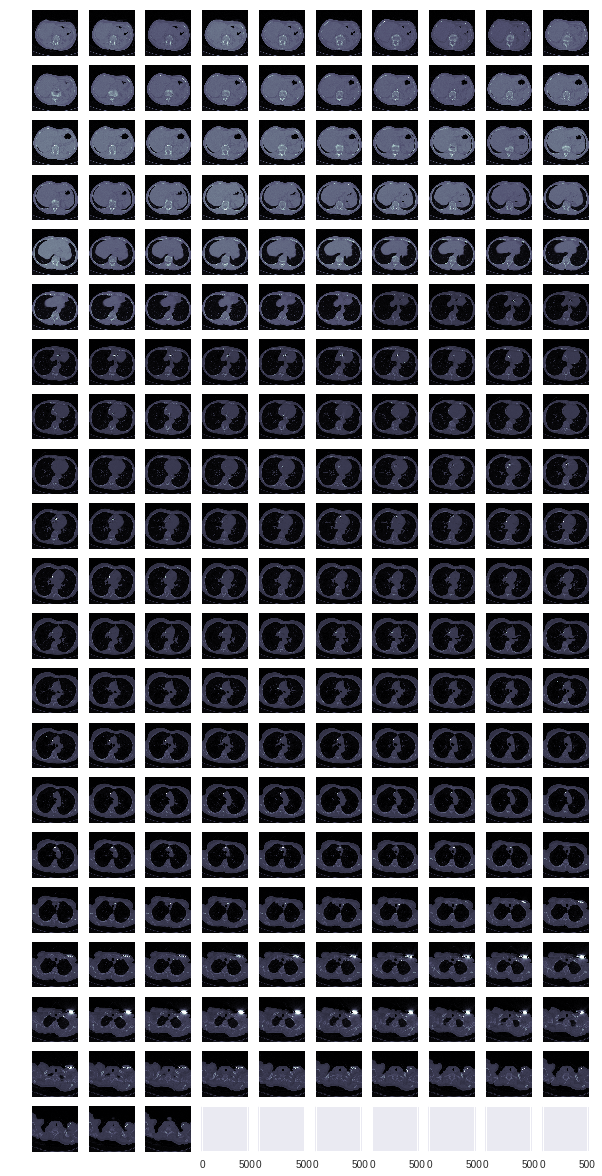

In [22]:
pat = load_patient('0acbebb8d463b4b9ca88cf38431aac69')
f, plots = plt.subplots(21, 10, sharex='all', sharey='all', figsize=(10, 21))
for i in range(203):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pat[i], cmap=plt.cm.bone)

Okay, so it looks like my theory that "Slice Position" refers to the z-position of the scan was correct (it probably said this in the documentation but who reads documentation??).

We can actually use this to reconstruct a 3D model of the of the torso by simply concatenating the images together. Then something like a 3D convolutional network could be applied on top in order to identify points of interest in 3D space. Interesting stuff.

I'm going to try to make an animated gif/video now, which should show this better than a bunch of plots. I've so far found no way to do this in python :(

In [23]:
# This function takes in a single frame from the DICOM and returns a single frame in RGB format.
def normalise(img):
    normed = (img / 14).astype(np.uint8) # Magic number, scaling to create int between 0 and 255
    img2 = np.zeros([*img.shape, 3], dtype=np.uint8)
    for i in range(3):
        img2[:, :, i] = normed
    return img2

In [24]:
npat = [normalise(p) for p in pat]

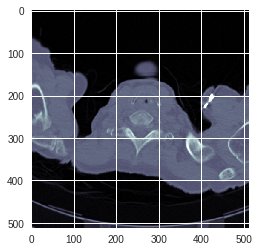

In [25]:
pat = load_patient('0acbebb8d463b4b9ca88cf38431aac69')

import matplotlib.animation as animation
def animate(pat, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(pat[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(pat[i])
        return anim,
    
    a = animation.FuncAnimation(fig, update, frames=range(len(pat)), interval=50, blit=True)
    a.save(gifname, writer='imagemagick')
    
animate(pat, 'test.gif')

![enter image description here][1]


  [1]: https://www.kaggle.io/svf/994809/5129153ac3ef32ff6abf72dc3b19dca5/test.gif